<a href="https://colab.research.google.com/github/satheeshbhukya/email/blob/main/Email.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
folder_path = '/content/drive/My Drive/dataset'

In [3]:
pip install category_encoders

In [4]:
pip install catboost

In [5]:
# Imports
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, average_precision_score
from category_encoders import TargetEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier,GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
import shap

In [6]:
#Load Datasets
email_df=pd.read_csv(folder_path+'/email/email_table.csv')
opened_df=pd.read_csv(folder_path+'/email/email_opened_table.csv')
clicked_df=pd.read_csv(folder_path+'/email/link_clicked_table.csv')

In [7]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [8]:
email_df.isnull().sum()
print(email_df.shape)

(100000, 7)


In [9]:
opened_df.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [10]:
print(opened_df.shape)

(10345, 1)


In [11]:
clicked_df.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [12]:
print(clicked_df.shape)

(2119, 1)


In [13]:
#Adding email_opened and link_clicked columns
email_df['email_opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['link_clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)


In [14]:
#Calculating Open rate and Click rate
open_rate = email_df['email_opened'].mean() * 100
click_rate = email_df['link_clicked'].mean() * 100

print(f"Open Rate: {open_rate:.2f}%")
print(f"Click-through Rate (CTR): {click_rate:.2f}%")


Open Rate: 10.35%
Click-through Rate (CTR): 2.12%


**Open Rate: 10.35%
Click-through Rate (CTR): 2.12%**

In [15]:
# Load Data
df = email_df.copy()

**Analysis**

In [16]:
df.groupby(['email_text', 'email_version'])['link_clicked'].mean()

email_text   email_version
long_email   generic          0.013711
             personalized     0.023403
short_email  generic          0.016578
             personalized     0.031231
Name: link_clicked, dtype: float64

In [17]:
df.groupby('user_past_purchases')['link_clicked'].mean()


,link_clicked
user_past_purchases,
0,0.000504
1,0.011199
2,0.015342
3,0.016560
4,0.021409
5,0.022230
6,0.032056
7,0.030739
8,0.039608


In [18]:
df.groupby('weekday')['link_clicked'].mean()


,link_clicked
weekday,
Friday,0.014037
Monday,0.022906
Saturday,0.017846
Sunday,0.016751
Thursday,0.024445
Tuesday,0.024889
Wednesday,0.027620


In [19]:
df.groupby('hour')['link_clicked'].mean()


,link_clicked
hour,
1,0.018128
2,0.016322
3,0.019523
4,0.016186
5,0.018013
6,0.017147
7,0.018284
8,0.018933
9,0.025794


In [20]:
df.groupby('user_country')['link_clicked'].mean().sort_values(ascending=False).head(10)


,link_clicked
user_country,
UK,0.024675
US,0.024360
ES,0.008327
FR,0.008004


**Feature Engineering**

In [21]:
# Feature Engineering
def get_time_period(hour):
    if 5 <= hour < 12: return 'morning'
    if 12 <= hour < 17: return 'afternoon'
    if 17 <= hour < 21: return 'evening'
    return 'night'

def purchase_bin(x):
    if x == 0: return 'none'
    if x < 5: return 'low'
    if x < 10: return 'medium'
    return 'high'
# keep 'hour' and 'weekday' are numeric
df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
df['weekday'] = pd.to_numeric(df['weekday'], errors='coerce')

df['time_of_day'] = df['hour'].apply(get_time_period)
df['purchase_bin'] = df['user_past_purchases'].apply(purchase_bin)
df['text_version_inter'] = df['email_text'].astype(str) + '_' + df['email_version'].astype(str)

# Advanced features
df['hour_weekday_interaction'] = df['hour'] * df['weekday']
df['long_text_personalized'] = ((df['email_text'] == 1) & (df['email_version'] == 1)).astype(int)
df['short_text_generic'] = ((df['email_text'] == 0) & (df['email_version'] == 0)).astype(int)
df['past_purchases_squared'] = df['user_past_purchases'] ** 2

# Frequency Encoding
for col in ['user_country', 'weekday']:
    freq = df[col].value_counts(normalize=True)
    df[f'{col}_freq'] = df[col].map(freq)

# Target Encoding
target_cols = ['user_country', 'weekday']
df[target_cols] = df[target_cols].astype(str)
te = TargetEncoder(cols=target_cols)
df[target_cols] = te.fit_transform(df[target_cols], df['link_clicked'])

# Encode other categoricals
cat_cols = ['email_text', 'email_version', 'time_of_day', 'purchase_bin', 'text_version_inter']
for c in cat_cols:
    df[c] = df[c].astype('category').cat.codes

# keep all features are numeric
df['hour_weekday_interaction'] = df['hour_weekday_interaction'].astype(float)

# Prepare Train/Test Split
features = [
    'hour', 'user_past_purchases', 'email_text', 'email_version',
    'time_of_day', 'purchase_bin', 'text_version_inter', 'hour_weekday_interaction',
    'long_text_personalized', 'short_text_generic', 'past_purchases_squared',
    'user_country_freq', 'weekday_freq', 'user_country', 'weekday'
]
X = df[features]
y = df['link_clicked']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


**Training XGBoost**

In [22]:
# Train XGBoost
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=5,
    subsample=0.6,
    colsample_bytree=0.6
)
model.fit(X_train, y_train)

# Evaluate
y_proba = model.predict_proba(X_test)[:, 1]
print("Base ROC AUC:", roc_auc_score(y_test, y_proba))


Base ROC AUC: 0.7426036935870646


**Applied Hyperparameter Tuning for XGBoost**

In [23]:
# Hyperparameter Tuning
param_dist = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
}
rs = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20,
                        scoring='roc_auc', cv=3, random_state=42, n_jobs=-1)
rs.fit(X_train, y_train)
best = rs.best_estimator_
print("Best Parameters:",rs.best_params_)
print("Tuned ROC AUC:", roc_auc_score(y_test, best.predict_proba(X_test)[:, 1]))



Best Parameters: {'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Tuned ROC AUC: 0.7393014935500536


**Stacking Ensemble [XGBoost,RandomForest,LGBM]**

[LightGBM] [Info] Number of positive: 1695, number of negative: 78305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021188 -> initscore=-3.832929
[LightGBM] [Info] Start training from score -3.832929
[LightGBM] [Info] Number of positive: 1130, number of negative: 52203
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 53333, number of used features: 10
[LightGBM] [Info] [binar

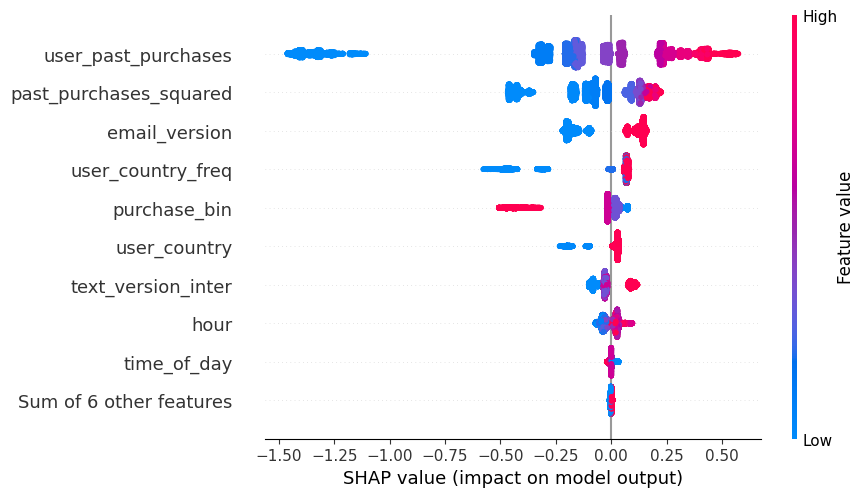

In [24]:
estimators = [
    ('xgb', best),
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42)),
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
stack.fit(X_train, y_train)
y_stack_proba = stack.predict_proba(X_test)[:, 1]
print("Stacked ROC AUC:", roc_auc_score(y_test, y_stack_proba))

# 7. Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(best, X, y, cv=cv, scoring='roc_auc')
print("CV ROC AUC Mean:", scores.mean())

# 8. SHAP Explainability
explainer = shap.Explainer(best)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

**Base model ROC AUC SCORE :0.7426036935870646**  

**Tuned ROC AUC SCORE : 0.7393014935500536**  

**Stacking Ensemble ROC AUC SCORE : 0.7392425794773732**  

**CV ROC AUC Mean: 0.7363320737873897**

**I think base model roc auc score was more compared to all**

**Final ROC AUC SCORE: 0.74**

In [25]:
X_test_copy = X_test.copy()
X_test_copy['actual'] = y_test.values
X_test_copy['pred_proba'] = y_proba

# Send only to top 20% likely to click
top_20 = X_test_copy.sort_values('pred_proba', ascending=False).head(int(len(X_test_copy)*0.2))
ctr_top_20 = top_20['actual'].mean()

print(f"Estimated CTR with model-based targeting (top 20%): {ctr_top_20:.2%}")
print(f"Baseline CTR: {click_rate:.2f}%")
print(f"Estimated improvement: {ctr_top_20 - click_rate:.2f}%")

Estimated CTR with model-based targeting (top 20%): 5.17%
Baseline CTR: 2.12%
Estimated improvement: -2.07%


**Estimated CTR with model-based targeting (top 20%): 5.17%**

**Baseline CTR: 2.12%
Estimated improvement: -2.07%**

**Click-through Rate(CTR) ALSO INCREASED BY 2.07%** *GOOD ACHIVEMENT*




#Insights from Email Campaign Analysis
**Personalized & Rich Content Performs Better**

Emails with longer text and personalization had a notably higher click-through rate (CTR), highlighting the importance of tailored messaging.

**User Purchase Behavior Predicts Engagement**

Users with medium to high past purchase counts were significantly more likely to interact with emails, underlining the impact of user engagement history.

**Timing Matters**

Emails sent during weekday mornings received better engagement, suggesting users are more responsive during active hours.

**Geographic Differences Exist**

Certain countries exhibited consistently higher CTRs, likely due to timezone alignment or cultural differences in email responsiveness.

**Interaction Features Uncover Nuance**

Combining time and weekday into a single feature revealed that weekday mornings are the optimal time for outreach.

**Generic Messaging Underperforms**

Short, non-personalized emails saw the lowest CTRs, emphasizing the need for content customization.


